# Installing Pytorch Geometric

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=e39f8dc7839d6631c2e67119145a412566072ee22147395b5ff8ee4bb6be39b7
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


# Importing Required Libraries

In [ ]:
# Importing the PyTorch library for general tensor computations and deep learning operations.
import torch

# Importing the PyTorch module for creating and working with neural networks.
import torch.nn as nn

# Importing the PyTorch module for implementing various optimization algorithms.
import torch.optim as optim

# Importing the PyTorch Geometric dataset module specifically for the Planetoid dataset, which contains citation network datasets.
from torch_geometric.datasets import Planetoid

# Importing the PyTorch Geometric module for implementing graph neural networks (GNNs).
import torch_geometric.nn as gnn

# Importing the PyTorch module for common non-linear activation functions and other functional operations.
import torch.nn.functional as F

# Importing the networkx library for working with graph data structures and algorithms.
import networkx as nx

# Importing the pandas library for data manipulation and analysis.
import pandas as pd
# import numpy library for array manipulation
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing feature encoders to demo an MLP on Graph Data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# Exploring the Dataset - Cora

The Cora dataset is a popular benchmark dataset used in the field of machine learning, particularly for graph-based supervised learning and node classification tasks.

The dataset represents a citation network consisting of scientific research papers from various areas, with a focus on machine learning. It contains 2,708 papers, each represented as a node in the graph. The edges in the graph represent the citations between the papers.

Each paper in the Cora dataset is associated with a bag-of-words feature representation, which represents the presence or absence of certain words in the paper. These features capture the content of the papers and are used as input for machine learning algorithms.

In addition to the features, each paper in the dataset is labeled with one of seven predefined classes, representing different research areas or topics. This makes the Cora dataset suitable for supervised learning tasks, such as node classification, where the goal is to predict the class label of unlabeled papers based on their features and the labeled papers in the graph.

## Downloading the Cora Dataset

In [ ]:
dataset = Planetoid(root='.', name='Cora')

Processing...
Done!


## Let's explore the Graph

### Num of Nodes and Edges. Also, the directionality of the Graph.

### The node features in the Cora dataset represent a dense, bag-of-words representation of the text contained within each paper. The feature vector has a length of 1433, corresponding to the vocabulary size of the dataset, where each position 'i' in the vector indicates the presence (1) or absence (0) of the 'i'-th word from the vocabulary within the given paper.

### There are, however, no Edge Features in this Dataset.

In [ ]:
# Get the graph from the dataset
data = dataset[0]
edge_index = data.edge_index # gives edges between a given pair of node indexesa
x = data.x
y = data.y

# Create a NetworkX graph from the edge index
G = nx.Graph()
G.add_edges_from(edge_index.t().tolist())

# Basic analysis
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
num_classes = y.max().item() + 1
num_node_features = data.num_node_features
num_edge_features = data.num_edge_features

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f'Is the Graph undirected: {data.is_undirected()}')

print(f"\nNumber of Node Features: {num_node_features}")
print(f"Number of Edge Features: {num_edge_features}")
print(f"Number of classes: {num_classes}")

Number of nodes: 2708
Number of edges: 5278
Is the Graph undirected: True

Number of Node Features: 1433
Number of Edge Features: 0
Number of classes: 7


## Distribution of Citations

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.89808,5.228784,1.0,2.0,3.0,5.0,168.0


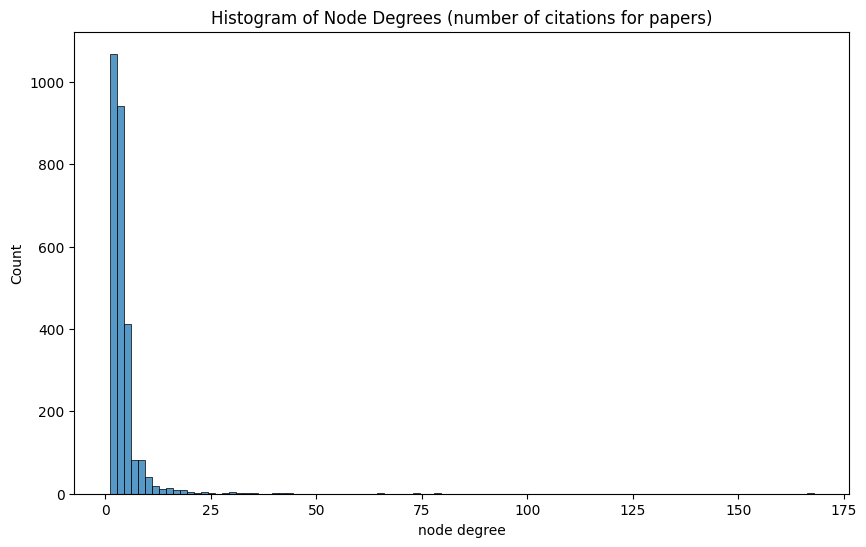

In [ ]:
# some code to help visualize what the number of citations look like (node degree)
node_degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(node_degrees).describe()).transpose())
plt.figure(figsize=(10, 6))
sns.histplot(node_degrees, bins=100)
plt.xlabel("node degree")
plt.title("Histogram of Node Degrees (number of citations for papers)")
plt.show()

A high degree in this case means that certain papers (nodes) are connected to many other papers (nodes). A good proxy for how "important" a paper is by looking at how many times it has been cited.

### Visualizing a node and corresponding connections

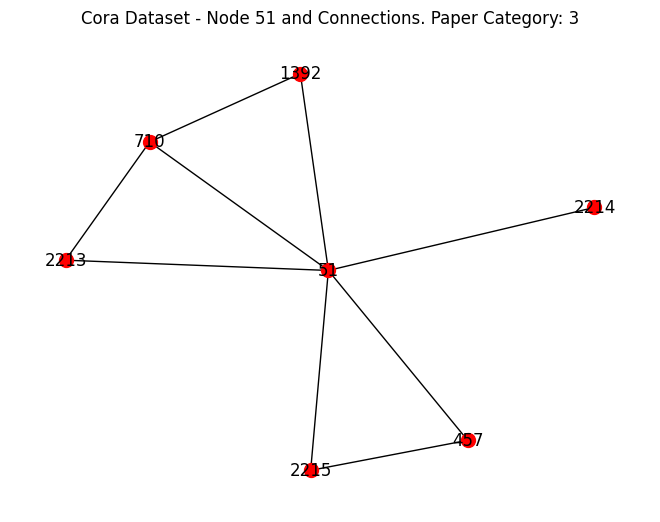

In [ ]:
def plot_node_subgraph(node_index):

  # Create a NetworkX graph from the edge index
  G = nx.Graph()
  G.add_edges_from(edge_index.t().tolist())

  # Get the subgraph for the specific node and its connections
  subgraph_nodes = [node_index] + list(G.neighbors(node_index))
  subgraph = G.subgraph(subgraph_nodes)

  # Plot the subgraph
  pos = nx.spring_layout(subgraph)
  nx.draw(subgraph, pos, node_color='red', node_size=100, with_labels=True)
  plt.title(f"Cora Dataset - Node {node_index} and Connections. Paper Category: {y[node_index]}")
  plt.show()

node_index = 51#0
plot_node_subgraph(node_index)

In [ ]:
# Calculate the degree for each node
degrees = [edge_index[1][edge_index[0] == i].size(0) for i in range(data.num_nodes)]

# Find the node index with the highest degree
node_index_with_highest_degree = max(range(data.num_nodes), key=lambda x: degrees[x])

# Print the node index and its degree
print(f"Node with highest degree: {node_index_with_highest_degree}")
print(f"Highest degree: {degrees[node_index_with_highest_degree]}")

Node with highest degree: 1358
Highest degree: 168


### Let's visualize this node

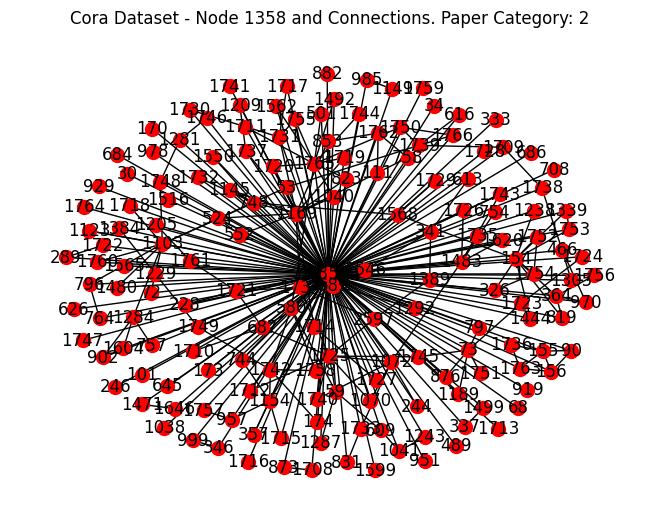

In [ ]:
node_index = 1358
plot_node_subgraph(node_index)

### Creating an Adjacency Matrix

In [ ]:
data.num_nodes

2708

In [ ]:
# Create an empty adjacency matrix of appropriate size
num_nodes = data.num_nodes
adj_matrix = torch.zeros((num_nodes, num_nodes))

# Fill the adjacency matrix based on the edges in the graph
adj_matrix[edge_index[0], edge_index[1]] = 1

# Convert the adjacency matrix to a Pandas DataFrame
adj_df = pd.DataFrame(adj_matrix.numpy())

# Filter the DataFrame to show only non-zero cells
non_zero_cells_df = adj_df.mask(adj_df == 0)

non_zero_cells_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2698,2699,2700,2701,2702,2703,2704,2705,2706,2707
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Let's checkout the adjacency for the node we visualized above

In [ ]:
# Specify the node index to view
node_index = 51

# Get the non-zero adjacency values for the specified node
non_zero_adjacencies = adj_df.loc[node_index][adj_df.loc[node_index] != 0]

# Print the node index and its non-zero adjacency values
print(f"Node {node_index}:")
print(non_zero_adjacencies)

Node 51:
457     1.0
710     1.0
1392    1.0
2213    1.0
2214    1.0
2215    1.0
Name: 51, dtype: float32


# Coding the GNN

### Basic Feed Forward Graph Convolutional Neural Network (GCNN) - Model Code

In the provided code, the **Graph Convolutional Network (GCN)** layers are used as building blocks in the graph neural network model. **GCN layers are specifically designed for graph-structured data and enable effective message passing and aggregation among neighbouring nodes in a graph.**

GCN layers implement the **message passing mechanism by aggregating information from the node's immediate neighbours and updating the node's representation based on the aggregated information.** This process allows each node to incorporate information from its local neighbourhood, capturing the relational dependencies within the graph.

In the code, the GNNModel class defines two GCN layers: **self.conv1 and self.conv2**. These layers perform the message passing operation by taking the input features (x) and the edge indices (edge_index) as inputs. **The forward method of the model applies these GCN layers sequentially to the input data, performing the message passing and updating the node representations.**

Specifically, in the forward method:

The **input features (x) and edge indices (edge_index) are passed through the first GCN layer (self.conv1)**, which performs message passing and updates the node representations.

The **ReLU activation function (torch.relu) is applied to introduce non-linearity** and increase the expressive power of the model.
The updated node representations are passed through the second GCN layer (self.conv2), performing another round of message passing and updating the node representations.

Finally, **the updated node representations are fed into a linear layer (self.fc) to produce the final classification logits**. **The softmax activation** is applied to the final linear layer to obtain a probability distribution over the classes.

By stacking multiple GCN layers and applying message passing iteratively, the model can capture complex relationships and dependencies within the graph structure. The GCN layers automatically handle the message passing process, aggregating information from neighbouring nodes and propagating it throughout the graph, enabling effective learning and representation of the graph-structured data.

In [ ]:
# Create the graph neural network model
class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super(GNNModel, self).__init__()

        # Define the graph convolution layers
        self.conv1 = gnn.GCNConv(num_features, hidden_size)
        self.conv2 = gnn.GCNConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Perform the first graph convolution layer and activation
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Perform the second graph convolution layer and activation
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # Perform the final linear classification
        x = self.fc(x)

        return torch.log_softmax(x, dim=1)

## Instantiate the GNN and Train

In [ ]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the GNN model
num_features = dataset.num_node_features
hidden_size = 16
num_classes = dataset.num_classes
model = GNNModel(num_features, hidden_size, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare the data
data = dataset[0].to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training and evaluation loop
def train_and_evaluate():
    model.train()
    optimizer.zero_grad()
    output = model(data)
    # Calculate the loss and accuracy for the training nodes
    train_loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])

    train_pred = output.argmax(dim=1)
    train_acc = (train_pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        # Calculate the loss and accuracy for the validation nodes
        val_loss = F.nll_loss(output[data.val_mask], data.y[data.val_mask])
        val_pred = output.argmax(dim=1)
        val_acc = (val_pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()


    return train_loss.item(), train_acc, val_loss.item(), val_acc

# Train the model
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc, val_loss, val_acc = train_and_evaluate()
    print(f'Epoch: {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


model.eval()
with torch.no_grad():
  # Calculate the loss and accuracy for the test nodes
  output = model(data)
  test_pred = output.argmax(dim=1)
  test_acc = (test_pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

  print(f'Test Accuracy: {test_acc}')


Epoch: 1/50, Train Loss: 1.9629, Train Accuracy: 0.1571, Validation Loss: 2.0164, Validation Accuracy: 0.1020
Epoch: 2/50, Train Loss: 1.9301, Train Accuracy: 0.2643, Validation Loss: 1.9992, Validation Accuracy: 0.1900
Epoch: 3/50, Train Loss: 1.8805, Train Accuracy: 0.3643, Validation Loss: 1.9679, Validation Accuracy: 0.2780
Epoch: 4/50, Train Loss: 1.8121, Train Accuracy: 0.3643, Validation Loss: 1.9176, Validation Accuracy: 0.2680
Epoch: 5/50, Train Loss: 1.7298, Train Accuracy: 0.3571, Validation Loss: 1.8554, Validation Accuracy: 0.2460
Epoch: 6/50, Train Loss: 1.6374, Train Accuracy: 0.4786, Validation Loss: 1.7884, Validation Accuracy: 0.2800
Epoch: 7/50, Train Loss: 1.5328, Train Accuracy: 0.5571, Validation Loss: 1.7190, Validation Accuracy: 0.3380
Epoch: 8/50, Train Loss: 1.4190, Train Accuracy: 0.6357, Validation Loss: 1.6436, Validation Accuracy: 0.4420
Epoch: 9/50, Train Loss: 1.2971, Train Accuracy: 0.7143, Validation Loss: 1.5570, Validation Accuracy: 0.5560
Epoch: 10/

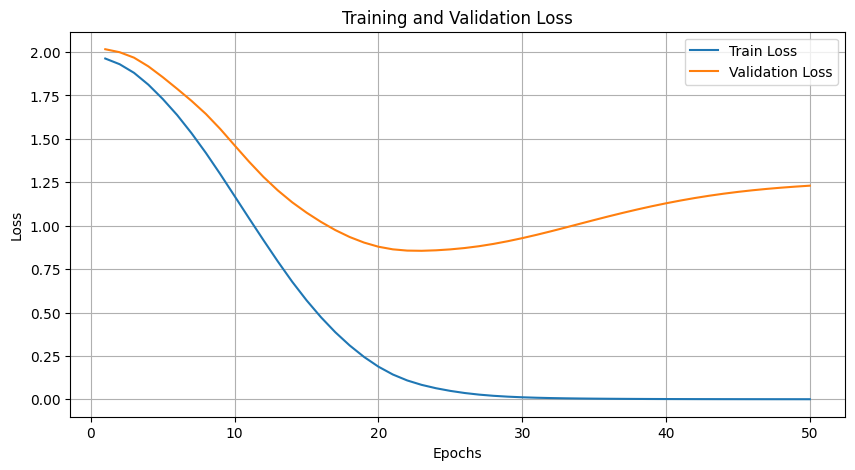

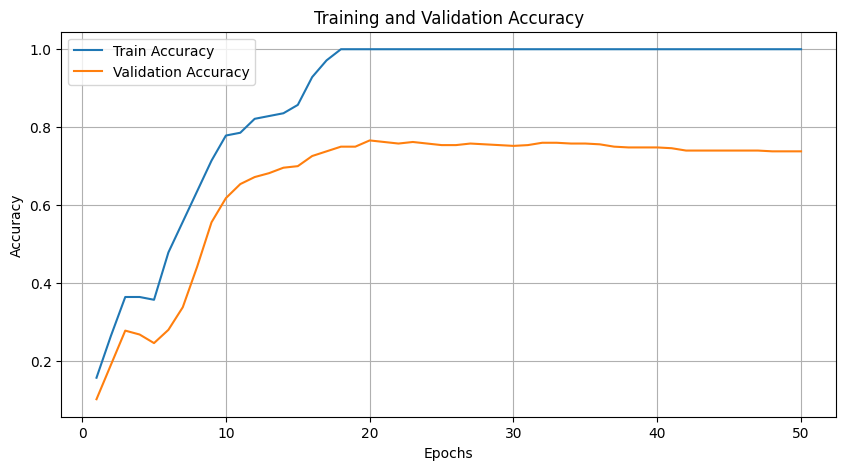

In [ ]:
# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrix for Test Dataset

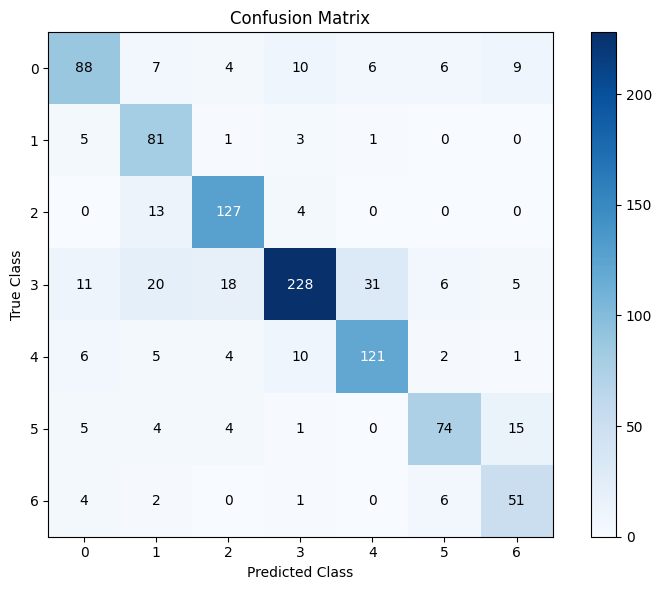

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    output = model(data)
    _, predicted = torch.max(output, 1)

# Convert the predicted and true labels to numpy arrays
predicted = predicted[data.test_mask].cpu().numpy()
true_labels = data.y[data.test_mask].cpu().numpy()

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted)

# Define class labels (assuming they are numeric)
class_labels = np.unique(true_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Add text labels inside each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.show()


## Now let's compare this performance with a Feed Forward Neural Network on the same Dataset

Regular Feed Forward Networks are not designed to work with Graph Data. That's because there is no straight forward methodology to encode the links/edges, along with a number of other challenges as discussed in the class.

In this case we are evaluating the same dataset using a Regular FFNN. However, we will only use node features and ignore the edge indices.

In [ ]:
node_features = data.x.numpy()
node_labels = data.y.numpy()


# Encode node labels (categories)
label_encoder = LabelEncoder()
node_labels = label_encoder.fit_transform(node_labels)

# Convert node features to PyTorch tensors
node_features = torch.tensor(node_features)
node_labels = torch.tensor(node_labels)

# Split the data
X_train, X_test, X_val, y_train, y_test, y_val = node_features[data.train_mask], node_features[data.test_mask], node_features[data.val_mask], node_labels[data.train_mask], node_labels[data.test_mask], node_labels[data.val_mask]

# Design the MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return torch.log_softmax(out, dim=1)

input_dim = X_train.shape[1]
hidden_dim = 16
output_dim = np.unique(node_labels).shape[0]
mlp = MLP(input_dim, hidden_dim, output_dim)

# Using the same Negative Log Likelihood Loss
criterion = nn.NLLLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

num_epochs = 100
batch_size = 32

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_batches = len(X_train) // batch_size

for epoch in range(num_epochs):
    train_acc_sum = 0
    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size

        optimizer.zero_grad()

        batch_inputs = X_train[start_idx:end_idx]
        batch_labels = y_train[start_idx:end_idx]

        outputs = mlp(batch_inputs)
        train_loss = criterion(outputs, batch_labels)
        train_labels_predicted = torch.argmax(outputs, dim=1).numpy()
        train_acc_sum += (train_labels_predicted == batch_labels.numpy()).mean()

        train_loss.backward()
        optimizer.step()

    train_acc = train_acc_sum/num_batches
    # Validation
    with torch.no_grad():
        val_outputs = mlp(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_labels_predicted = torch.argmax(val_outputs, dim=1).numpy()
        val_labels_true = y_val.numpy()
        val_acc = (val_labels_predicted == val_labels_true).mean()

    print(f"Epoch: {epoch+1}/{num_epochs}, Training Loss: {train_loss.item():.4f}, Training Accuracy: {train_acc:.2f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_acc}")

    train_accuracies.append(train_acc)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

# Evaluate the MLP
with torch.no_grad():
    test_outputs = mlp(X_test)
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()
    true_labels = y_test.numpy()

    accuracy = (predicted_labels == true_labels).mean()
    print(f"Test Accuracy: {accuracy:.4f}")

Epoch: 1/100, Training Loss: 1.9252, Training Accuracy: 0.17, Validation Loss: 1.9167, Validation Accuracy: 0.316
Epoch: 2/100, Training Loss: 1.9020, Training Accuracy: 0.20, Validation Loss: 1.9111, Validation Accuracy: 0.322
Epoch: 3/100, Training Loss: 1.8770, Training Accuracy: 0.26, Validation Loss: 1.9043, Validation Accuracy: 0.324
Epoch: 4/100, Training Loss: 1.8495, Training Accuracy: 0.30, Validation Loss: 1.8958, Validation Accuracy: 0.338
Epoch: 5/100, Training Loss: 1.8181, Training Accuracy: 0.38, Validation Loss: 1.8858, Validation Accuracy: 0.352
Epoch: 6/100, Training Loss: 1.7835, Training Accuracy: 0.44, Validation Loss: 1.8742, Validation Accuracy: 0.364
Epoch: 7/100, Training Loss: 1.7459, Training Accuracy: 0.48, Validation Loss: 1.8615, Validation Accuracy: 0.39
Epoch: 8/100, Training Loss: 1.7057, Training Accuracy: 0.55, Validation Loss: 1.8480, Validation Accuracy: 0.416
Epoch: 9/100, Training Loss: 1.6622, Training Accuracy: 0.62, Validation Loss: 1.8337, Va

### Significant loss in accuracy. Let's look at the loss and accuracy curves.

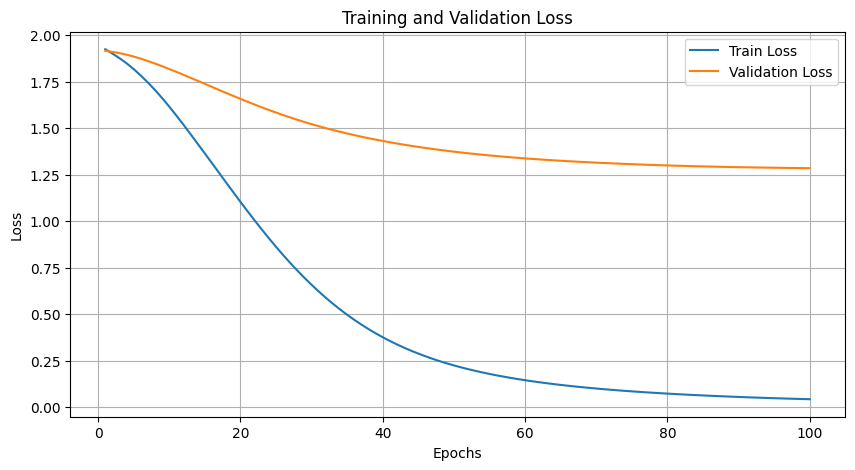

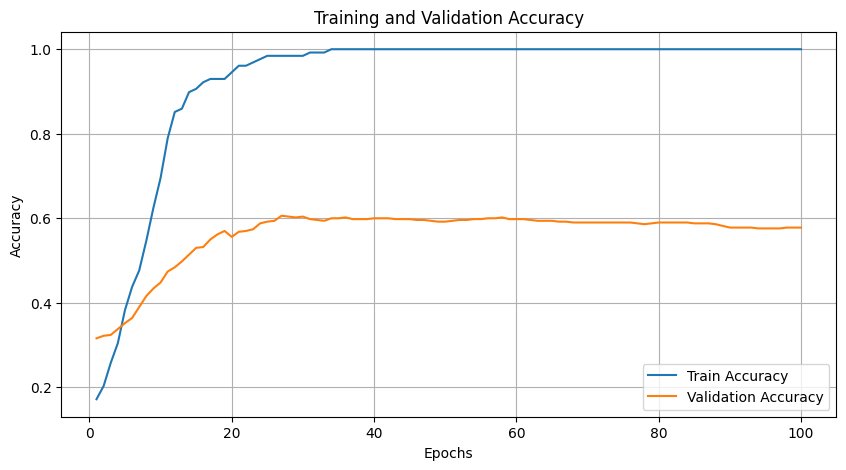

In [ ]:
# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model stops learning after about 30 epochs (and also overfits too fast). The confusion matrix given below shows similar performance degradation.

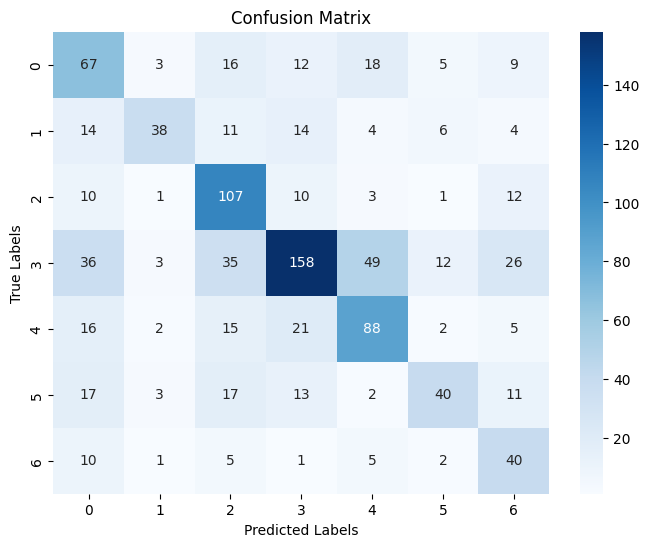

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the unique labels in the dataset
unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
